In [1]:
import tensorflow as tf

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce RTX 2080, pci bus id: 0000:02:00.0, compute capability: 7.5



In [3]:
tf.test.is_gpu_available()

True

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Dropout, UpSampling2D, Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
import PIL
from PIL import Image

In [8]:
def custom_ssim(y_actual, y_predicted):
    y_actual = (1+y_actual)/2
    y_predicted = (1+y_predicted)/2
    return 1 - tf.image.ssim(y_actual, y_predicted, max_val=1)

In [9]:
num_train3 = 15 
num_train5 = 14 
num_test3 = 3
num_test5 = 3

In [10]:
blurred_train_aux = np.zeros((num_train3 + num_train5, 256, 256, 3))
original_train_aux = np.zeros((num_train3 + num_train5, 256, 256, 3))

for i in range (1, num_train3+1):
    blurred_train_aux[i-1, :, :, :] = np.load('amostras_rgb/sigma3(7, 7)/arrays/treino' + str(i) + '.npy')
    original_train_aux[i-1, :, :, :] = np.load('amostras_rgb/original/arrays/treino' + str(i) + '.npy')
    
for i in range (num_train3+1, num_train3+num_train5+1):
    blurred_train_aux[i-1, :, :, :] = np.load('amostras_rgb/sigma5(7, 7)/arrays/treino' + str(i) + '.npy')
    original_train_aux[i-1, :, :, :] = np.load('amostras_rgb/original/arrays/treino' + str(i) + '.npy')

In [11]:
blurred_train_aux = blurred_train_aux/(blurred_train_aux.max())
original_train_aux = original_train_aux/(original_train_aux.max())

In [12]:
blurred_train = 2*blurred_train_aux - 1
original_train = 2*original_train_aux - 1

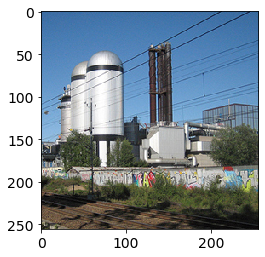

In [13]:
plt.imshow(original_train_aux[0, :, :, :])

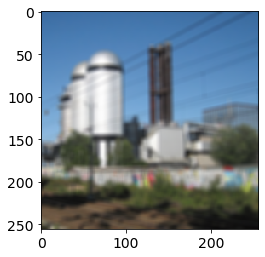

In [14]:
plt.imshow(blurred_train_aux[0, :, :, :])

In [15]:
blurred_train_tf = tf.convert_to_tensor(blurred_train_aux)
original_train_tf = tf.convert_to_tensor(original_train_aux)

In [16]:
blurred_test_aux = np.zeros((num_test3 + num_test5, 256, 256, 3))
original_test_aux = np.zeros((num_test3 + num_test5, 256, 256, 3))

for i in range (1, num_test3+1):
    blurred_test_aux[i-1, :, :, :] = np.load('amostras_rgb/sigma3(7, 7)/arrays/teste' + str(i) + '.npy')
    original_test_aux[i-1, :, :, :] = np.load('amostras_rgb/original/arrays/teste' + str(i) + '.npy')
    
for i in range (1, num_test5+1):
    blurred_test_aux[i-1+num_test3, :, :, :] = np.load('amostras_rgb/sigma5(7, 7)/arrays/teste' + str(i) + '.npy')
    original_test_aux[i-1+num_test3, :, :, :] = np.load('amostras_rgb/original/arrays/teste' + str(i) + '.npy')

In [17]:
blurred_test_aux = blurred_test_aux/(blurred_test_aux.max())
original_test_aux = original_test_aux/(original_test_aux.max())

In [18]:
blurred_test = 2*blurred_test_aux - 1
original_test = 2*original_test_aux - 1

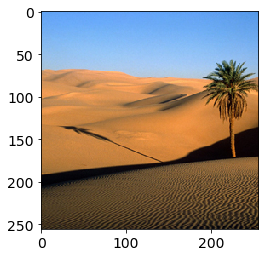

In [19]:
plt.imshow(original_test_aux[0, :, :, :])

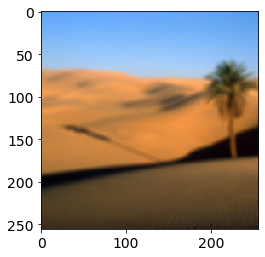

In [20]:
plt.imshow(blurred_test_aux[0, :, :, :])

In [21]:
blurred_test_tf = tf.convert_to_tensor(blurred_test_aux)
original_test_tf = tf.convert_to_tensor(original_test_aux)

In [22]:
def make_autoencoder(input_shape):
  
    X_input = Input(input_shape)

    #comprimindo a imagem
    X = Conv2D(3, (7, 7), padding="same", name='conv0')(X_input)
    X0 = Activation('tanh')(X)
    
    X = Conv2D(4, (7, 7), padding="same", name='conv1')(X0)
    X1 = Activation('tanh')(X)
    
    X = Conv2D(8, (7, 7), padding="same", name='conv2')(X1)
    X2 = Activation('tanh')(X)
    
    X = Conv2D(16, (7, 7), padding="same", name='conv3')(X2)
    X3 = Activation('tanh')(X)
    
    X = Conv2D(32, (7, 7), padding="same", name='conv4')(X3)
    X = Activation('tanh')(X)
    
    #camada latente 
    
    #descomprimindo a imagem
    X = Conv2DTranspose(16, (7, 7), padding="same", name='deconv0')(X)
    X = Activation('tanh')(X)
    X = Add()([X3, X])
    
    X = Conv2DTranspose(8, (7, 7), padding="same", name='deconv1')(X)
    X = Activation('tanh')(X)
    X = Add()([X2, X])
    
    X = Conv2DTranspose(4, (7, 7), padding="same", name='deconv2')(X)
    X = Activation('tanh')(X)
    X = Add()([X1, X])
    
    X = Conv2DTranspose(3, (7, 7), padding="same", name='deconv3')(X)
    X = Activation('tanh')(X)
    X = Add()([X0, X])
    
    X = Conv2DTranspose(3, (7, 7), padding="same", name='deconv4')(X)
    X = Activation('tanh')(X)
    

    model = Model(inputs=X_input, outputs=X, name='model')
    
    return model

In [23]:
mirrored_strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

Number of devices: 2


In [24]:
opt = Adam(lr=1e-4)

In [25]:
with mirrored_strategy.scope():
    model = make_autoencoder(original_train.shape[1:])
    model.compile(optimizer=opt, loss=custom_ssim)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 3)  444         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 3)  0           conv0[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 4)  592         activation[0][0]                 
______________________________________________________________________________________________

In [27]:
history = model.fit(x=blurred_train, y=original_train, epochs=20000, validation_data=[blurred_test, original_test])

Train on 29 samples, validate on 6 samples
Epoch 1/20000
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 20 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then bro

Epoch 69/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.4162 - val_loss: 0.3490
Epoch 70/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.4143 - val_loss: 0.3472
Epoch 71/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.4137 - val_loss: 0.3456
Epoch 72/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.4115 - val_loss: 0.3441
Epoch 73/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.4099 - val_loss: 0.3427
Epoch 74/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.4080 - val_loss: 0.3413
Epoch 75/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.4066 - val_loss: 0.3398
Epoch 76/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.4048 - val_loss: 0.3384
Epoch 77/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.4038 - val_loss: 0.3369
Epoch 78/20000
29/29 [==============================] - 0s 9ms/s

Epoch 148/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3462 - val_loss: 0.2786
Epoch 149/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3456 - val_loss: 0.2782
Epoch 150/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3448 - val_loss: 0.2776
Epoch 151/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3448 - val_loss: 0.2771
Epoch 152/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.3438 - val_loss: 0.2766
Epoch 153/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3438 - val_loss: 0.2761
Epoch 154/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3439 - val_loss: 0.2756
Epoch 155/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.3432 - val_loss: 0.2752
Epoch 156/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3426 - val_loss: 0.2747
Epoch 157/20000
29/29 [==============================

Epoch 226/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3129 - val_loss: 0.2487
Epoch 227/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3117 - val_loss: 0.2485
Epoch 228/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3127 - val_loss: 0.2481
Epoch 229/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3121 - val_loss: 0.2477
Epoch 230/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3126 - val_loss: 0.2476
Epoch 231/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3116 - val_loss: 0.2471
Epoch 232/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3107 - val_loss: 0.2466
Epoch 233/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3106 - val_loss: 0.2466
Epoch 234/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.3088 - val_loss: 0.2462
Epoch 235/20000
29/29 [==============================] 

Epoch 304/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2878 - val_loss: 0.2267
Epoch 305/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2871 - val_loss: 0.2257
Epoch 306/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2862 - val_loss: 0.2256
Epoch 307/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2868 - val_loss: 0.2259
Epoch 308/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2854 - val_loss: 0.2248
Epoch 309/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2851 - val_loss: 0.2251
Epoch 310/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2859 - val_loss: 0.2247
Epoch 311/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2837 - val_loss: 0.2241
Epoch 312/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2843 - val_loss: 0.2247
Epoch 313/20000
29/29 [==============================]

Epoch 382/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2673 - val_loss: 0.2099
Epoch 383/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2673 - val_loss: 0.2103
Epoch 384/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2659 - val_loss: 0.2103
Epoch 385/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2659 - val_loss: 0.2094
Epoch 386/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2665 - val_loss: 0.2104
Epoch 387/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2666 - val_loss: 0.2091
Epoch 388/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2649 - val_loss: 0.2097
Epoch 389/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2652 - val_loss: 0.2092
Epoch 390/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2651 - val_loss: 0.2090
Epoch 391/20000
29/29 [==============================]

Epoch 460/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2530 - val_loss: 0.2002
Epoch 461/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2524 - val_loss: 0.2007
Epoch 462/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2535 - val_loss: 0.2002
Epoch 463/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2515 - val_loss: 0.2002
Epoch 464/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2521 - val_loss: 0.2002
Epoch 465/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2518 - val_loss: 0.1998
Epoch 466/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2525 - val_loss: 0.2001
Epoch 467/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2537 - val_loss: 0.1997
Epoch 468/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2514 - val_loss: 0.1997
Epoch 469/20000
29/29 [==============================]

Epoch 538/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2426 - val_loss: 0.1934
Epoch 539/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2424 - val_loss: 0.1936
Epoch 540/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2434 - val_loss: 0.1931
Epoch 541/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2424 - val_loss: 0.1936
Epoch 542/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2416 - val_loss: 0.1930
Epoch 543/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2426 - val_loss: 0.1933
Epoch 544/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2423 - val_loss: 0.1931
Epoch 545/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2418 - val_loss: 0.1928
Epoch 546/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2412 - val_loss: 0.1933
Epoch 547/20000
29/29 [==============================]

Epoch 616/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2334 - val_loss: 0.1885
Epoch 617/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2344 - val_loss: 0.1875
Epoch 618/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2343 - val_loss: 0.1884
Epoch 619/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2341 - val_loss: 0.1875
Epoch 620/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2338 - val_loss: 0.1882
Epoch 621/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2342 - val_loss: 0.1874
Epoch 622/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2329 - val_loss: 0.1877
Epoch 623/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2329 - val_loss: 0.1874
Epoch 624/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2336 - val_loss: 0.1874
Epoch 625/20000
29/29 [==============================] 

Epoch 694/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2262 - val_loss: 0.1842
Epoch 695/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2261 - val_loss: 0.1826
Epoch 696/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2264 - val_loss: 0.1848
Epoch 697/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2273 - val_loss: 0.1824
Epoch 698/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2272 - val_loss: 0.1850
Epoch 699/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2275 - val_loss: 0.1824
Epoch 700/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2268 - val_loss: 0.1842
Epoch 701/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2261 - val_loss: 0.1828
Epoch 702/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2268 - val_loss: 0.1829
Epoch 703/20000
29/29 [=============================

Epoch 772/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2211 - val_loss: 0.1796
Epoch 773/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2202 - val_loss: 0.1793
Epoch 774/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2203 - val_loss: 0.1795
Epoch 775/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2201 - val_loss: 0.1793
Epoch 776/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2203 - val_loss: 0.1793
Epoch 777/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2208 - val_loss: 0.1792
Epoch 778/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2205 - val_loss: 0.1792
Epoch 779/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2192 - val_loss: 0.1790
Epoch 780/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2202 - val_loss: 0.1792
Epoch 781/20000
29/29 [=============================

Epoch 850/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2161 - val_loss: 0.1760
Epoch 851/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2153 - val_loss: 0.1763
Epoch 852/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2158 - val_loss: 0.1759
Epoch 853/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2160 - val_loss: 0.1763
Epoch 854/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2164 - val_loss: 0.1757
Epoch 855/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2160 - val_loss: 0.1765
Epoch 856/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2156 - val_loss: 0.1754
Epoch 857/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2157 - val_loss: 0.1768
Epoch 858/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2156 - val_loss: 0.1752
Epoch 859/20000
29/29 [=============================

Epoch 928/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2115 - val_loss: 0.1734
Epoch 929/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2119 - val_loss: 0.1734
Epoch 930/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2110 - val_loss: 0.1734
Epoch 931/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2118 - val_loss: 0.1732
Epoch 932/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2112 - val_loss: 0.1735
Epoch 933/20000
29/29 [==============================] - 0s 8ms/sample - loss: 0.2119 - val_loss: 0.1733
Epoch 934/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2111 - val_loss: 0.1742
Epoch 935/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2123 - val_loss: 0.1737
Epoch 936/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2120 - val_loss: 0.1744
Epoch 937/20000
29/29 [============================

Epoch 1006/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2091 - val_loss: 0.1706
Epoch 1007/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2089 - val_loss: 0.1722
Epoch 1008/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2089 - val_loss: 0.1703
Epoch 1009/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2081 - val_loss: 0.1723
Epoch 1010/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2079 - val_loss: 0.1705
Epoch 1011/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2076 - val_loss: 0.1726
Epoch 1012/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2092 - val_loss: 0.1705
Epoch 1013/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2084 - val_loss: 0.1720
Epoch 1014/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2090 - val_loss: 0.1705
Epoch 1015/20000
29/29 [===================

29/29 [==============================] - 0s 9ms/sample - loss: 0.2072 - val_loss: 0.1728
Epoch 1084/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2071 - val_loss: 0.1683
Epoch 1085/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2070 - val_loss: 0.1705
Epoch 1086/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2062 - val_loss: 0.1693
Epoch 1087/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2054 - val_loss: 0.1683
Epoch 1088/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2061 - val_loss: 0.1714
Epoch 1089/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2064 - val_loss: 0.1684
Epoch 1090/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2067 - val_loss: 0.1692
Epoch 1091/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2056 - val_loss: 0.1700
Epoch 1092/20000
29/29 [==============================] - 0s

Epoch 1161/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2037 - val_loss: 0.1671
Epoch 1162/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2028 - val_loss: 0.1670
Epoch 1163/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2026 - val_loss: 0.1670
Epoch 1164/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2033 - val_loss: 0.1670
Epoch 1165/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2034 - val_loss: 0.1670
Epoch 1166/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2024 - val_loss: 0.1670
Epoch 1167/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2032 - val_loss: 0.1668
Epoch 1168/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2029 - val_loss: 0.1669
Epoch 1169/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2029 - val_loss: 0.1669
Epoch 1170/20000
29/29 [===================

29/29 [==============================] - 0s 9ms/sample - loss: 0.2007 - val_loss: 0.1661
Epoch 1239/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2010 - val_loss: 0.1648
Epoch 1240/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2011 - val_loss: 0.1669
Epoch 1241/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2011 - val_loss: 0.1648
Epoch 1242/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2017 - val_loss: 0.1678
Epoch 1243/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2018 - val_loss: 0.1646
Epoch 1244/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2012 - val_loss: 0.1672
Epoch 1245/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.2012 - val_loss: 0.1647
Epoch 1246/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.2008 - val_loss: 0.1656
Epoch 1247/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 9ms/sample - loss: 0.1986 - val_loss: 0.1640
Epoch 1316/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1982 - val_loss: 0.1634
Epoch 1317/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1979 - val_loss: 0.1641
Epoch 1318/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1984 - val_loss: 0.1632
Epoch 1319/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1986 - val_loss: 0.1644
Epoch 1320/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1987 - val_loss: 0.1631
Epoch 1321/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1981 - val_loss: 0.1651
Epoch 1322/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1990 - val_loss: 0.1629
Epoch 1323/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1993 - val_loss: 0.1660
Epoch 1324/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 10ms/sample - loss: 0.1970 - val_loss: 0.1621
Epoch 1393/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1963 - val_loss: 0.1625
Epoch 1394/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1955 - val_loss: 0.1621
Epoch 1395/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1960 - val_loss: 0.1624
Epoch 1396/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1962 - val_loss: 0.1622
Epoch 1397/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1961 - val_loss: 0.1623
Epoch 1398/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1959 - val_loss: 0.1623
Epoch 1399/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1959 - val_loss: 0.1622
Epoch 1400/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1963 - val_loss: 0.1623
Epoch 1401/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 10ms/sample - loss: 0.1947 - val_loss: 0.1606
Epoch 1470/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1952 - val_loss: 0.1618
Epoch 1471/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1945 - val_loss: 0.1605
Epoch 1472/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1944 - val_loss: 0.1621
Epoch 1473/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1947 - val_loss: 0.1604
Epoch 1474/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1941 - val_loss: 0.1623
Epoch 1475/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1950 - val_loss: 0.1605
Epoch 1476/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1945 - val_loss: 0.1619
Epoch 1477/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1946 - val_loss: 0.1605
Epoch 1478/20000
29/29 [==============================] - 

29/29 [==============================] - 0s 9ms/sample - loss: 0.1934 - val_loss: 0.1610
Epoch 1547/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1925 - val_loss: 0.1591
Epoch 1548/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1928 - val_loss: 0.1605
Epoch 1549/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1925 - val_loss: 0.1593
Epoch 1550/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1924 - val_loss: 0.1598
Epoch 1551/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1927 - val_loss: 0.1597
Epoch 1552/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1924 - val_loss: 0.1594
Epoch 1553/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1920 - val_loss: 0.1601
Epoch 1554/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1935 - val_loss: 0.1592
Epoch 1555/20000
29/29 [==============================] -

29/29 [==============================] - 0s 9ms/sample - loss: 0.1916 - val_loss: 0.1594
Epoch 1624/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1912 - val_loss: 0.1580
Epoch 1625/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1912 - val_loss: 0.1596
Epoch 1626/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1914 - val_loss: 0.1579
Epoch 1627/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1912 - val_loss: 0.1593
Epoch 1628/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1910 - val_loss: 0.1581
Epoch 1629/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1919 - val_loss: 0.1589
Epoch 1630/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1914 - val_loss: 0.1584
Epoch 1631/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1908 - val_loss: 0.1585
Epoch 1632/20000
29/29 [==============================] - 0s 

29/29 [==============================] - 0s 9ms/sample - loss: 0.1910 - val_loss: 0.1586
Epoch 1701/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1898 - val_loss: 0.1571
Epoch 1702/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1897 - val_loss: 0.1582
Epoch 1703/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1899 - val_loss: 0.1573
Epoch 1704/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1899 - val_loss: 0.1577
Epoch 1705/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1901 - val_loss: 0.1577
Epoch 1706/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1905 - val_loss: 0.1573
Epoch 1707/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1893 - val_loss: 0.1580
Epoch 1708/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1901 - val_loss: 0.1571
Epoch 1709/20000
29/29 [==============================] - 0

Epoch 1778/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1895 - val_loss: 0.1572
Epoch 1779/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1886 - val_loss: 0.1568
Epoch 1780/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1892 - val_loss: 0.1566
Epoch 1781/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1887 - val_loss: 0.1570
Epoch 1782/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1887 - val_loss: 0.1563
Epoch 1783/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1884 - val_loss: 0.1572
Epoch 1784/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1885 - val_loss: 0.1562
Epoch 1785/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1884 - val_loss: 0.1572
Epoch 1786/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1880 - val_loss: 0.1563
Epoch 1787/20000
29/29 [==================

Epoch 1855/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1878 - val_loss: 0.1561
Epoch 1856/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1874 - val_loss: 0.1558
Epoch 1857/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1871 - val_loss: 0.1557
Epoch 1858/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1872 - val_loss: 0.1561
Epoch 1859/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1873 - val_loss: 0.1556
Epoch 1860/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1872 - val_loss: 0.1560
Epoch 1861/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1874 - val_loss: 0.1558
Epoch 1862/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1873 - val_loss: 0.1557
Epoch 1863/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1872 - val_loss: 0.1558
Epoch 1864/20000
29/29 [==================

Epoch 1932/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1872 - val_loss: 0.1552
Epoch 1933/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1861 - val_loss: 0.1552
Epoch 1934/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1865 - val_loss: 0.1551
Epoch 1935/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1862 - val_loss: 0.1552
Epoch 1936/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1867 - val_loss: 0.1553
Epoch 1937/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1862 - val_loss: 0.1550
Epoch 1938/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1863 - val_loss: 0.1556
Epoch 1939/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1861 - val_loss: 0.1546
Epoch 1940/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1867 - val_loss: 0.1563
Epoch 1941/20000
29/29 [==================

Epoch 2009/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1849 - val_loss: 0.1543
Epoch 2010/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1854 - val_loss: 0.1546
Epoch 2011/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1853 - val_loss: 0.1544
Epoch 2012/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1856 - val_loss: 0.1545
Epoch 2013/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1849 - val_loss: 0.1545
Epoch 2014/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1846 - val_loss: 0.1544
Epoch 2015/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1854 - val_loss: 0.1546
Epoch 2016/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1855 - val_loss: 0.1541
Epoch 2017/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1852 - val_loss: 0.1548
Epoch 2018/20000
29/29 [================

Epoch 2086/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1838 - val_loss: 0.1541
Epoch 2087/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1845 - val_loss: 0.1535
Epoch 2088/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1844 - val_loss: 0.1541
Epoch 2089/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1846 - val_loss: 0.1535
Epoch 2090/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1841 - val_loss: 0.1541
Epoch 2091/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1845 - val_loss: 0.1535
Epoch 2092/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1842 - val_loss: 0.1541
Epoch 2093/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1838 - val_loss: 0.1536
Epoch 2094/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1840 - val_loss: 0.1542
Epoch 2095/20000
29/29 [==================

Epoch 2163/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1840 - val_loss: 0.1529
Epoch 2164/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1833 - val_loss: 0.1537
Epoch 2165/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1836 - val_loss: 0.1528
Epoch 2166/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1839 - val_loss: 0.1537
Epoch 2167/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1834 - val_loss: 0.1527
Epoch 2168/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1829 - val_loss: 0.1537
Epoch 2169/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1825 - val_loss: 0.1527
Epoch 2170/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1836 - val_loss: 0.1538
Epoch 2171/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1838 - val_loss: 0.1527
Epoch 2172/20000
29/29 [==================

Epoch 2240/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1823 - val_loss: 0.1531
Epoch 2241/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1831 - val_loss: 0.1523
Epoch 2242/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1824 - val_loss: 0.1532
Epoch 2243/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1827 - val_loss: 0.1522
Epoch 2244/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1826 - val_loss: 0.1532
Epoch 2245/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1828 - val_loss: 0.1522
Epoch 2246/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1825 - val_loss: 0.1532
Epoch 2247/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1819 - val_loss: 0.1521
Epoch 2248/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1822 - val_loss: 0.1534
Epoch 2249/20000
29/29 [=================

Epoch 2317/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1819 - val_loss: 0.1525
Epoch 2318/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1816 - val_loss: 0.1521
Epoch 2319/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1823 - val_loss: 0.1525
Epoch 2320/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1819 - val_loss: 0.1520
Epoch 2321/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1824 - val_loss: 0.1524
Epoch 2322/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1817 - val_loss: 0.1519
Epoch 2323/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1823 - val_loss: 0.1524
Epoch 2324/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1822 - val_loss: 0.1519
Epoch 2325/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1816 - val_loss: 0.1524
Epoch 2326/20000
29/29 [==================

Epoch 2394/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1807 - val_loss: 0.1520
Epoch 2395/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1816 - val_loss: 0.1515
Epoch 2396/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1812 - val_loss: 0.1518
Epoch 2397/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1812 - val_loss: 0.1516
Epoch 2398/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1811 - val_loss: 0.1517
Epoch 2399/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1809 - val_loss: 0.1516
Epoch 2400/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1805 - val_loss: 0.1516
Epoch 2401/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1808 - val_loss: 0.1517
Epoch 2402/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1814 - val_loss: 0.1517
Epoch 2403/20000
29/29 [===================

Epoch 2471/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1806 - val_loss: 0.1515
Epoch 2472/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1802 - val_loss: 0.1512
Epoch 2473/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1805 - val_loss: 0.1515
Epoch 2474/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1804 - val_loss: 0.1512
Epoch 2475/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1809 - val_loss: 0.1514
Epoch 2476/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1806 - val_loss: 0.1514
Epoch 2477/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1807 - val_loss: 0.1513
Epoch 2478/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1810 - val_loss: 0.1515
Epoch 2479/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1808 - val_loss: 0.1515
Epoch 2480/20000
29/29 [=================

Epoch 2548/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1797 - val_loss: 0.1509
Epoch 2549/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1797 - val_loss: 0.1512
Epoch 2550/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1801 - val_loss: 0.1509
Epoch 2551/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1805 - val_loss: 0.1510
Epoch 2552/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1796 - val_loss: 0.1508
Epoch 2553/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1792 - val_loss: 0.1508
Epoch 2554/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1793 - val_loss: 0.1508
Epoch 2555/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1794 - val_loss: 0.1508
Epoch 2556/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1794 - val_loss: 0.1509
Epoch 2557/20000
29/29 [==================

Epoch 2625/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1796 - val_loss: 0.1511
Epoch 2626/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1793 - val_loss: 0.1506
Epoch 2627/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1793 - val_loss: 0.1511
Epoch 2628/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1794 - val_loss: 0.1503
Epoch 2629/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1791 - val_loss: 0.1510
Epoch 2630/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1795 - val_loss: 0.1502
Epoch 2631/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1793 - val_loss: 0.1509
Epoch 2632/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1792 - val_loss: 0.1502
Epoch 2633/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1793 - val_loss: 0.1508
Epoch 2634/20000
29/29 [==================

Epoch 2702/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1780 - val_loss: 0.1508
Epoch 2703/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1782 - val_loss: 0.1501
Epoch 2704/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1786 - val_loss: 0.1501
Epoch 2705/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1784 - val_loss: 0.1506
Epoch 2706/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1786 - val_loss: 0.1497
Epoch 2707/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1782 - val_loss: 0.1509
Epoch 2708/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1787 - val_loss: 0.1496
Epoch 2709/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1790 - val_loss: 0.1510
Epoch 2710/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1790 - val_loss: 0.1497
Epoch 2711/20000
29/29 [===============

Epoch 2779/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1780 - val_loss: 0.1497
Epoch 2780/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1777 - val_loss: 0.1500
Epoch 2781/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1779 - val_loss: 0.1496
Epoch 2782/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1782 - val_loss: 0.1501
Epoch 2783/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1779 - val_loss: 0.1494
Epoch 2784/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1786 - val_loss: 0.1504
Epoch 2785/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1777 - val_loss: 0.1493
Epoch 2786/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1786 - val_loss: 0.1509
Epoch 2787/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1778 - val_loss: 0.1491
Epoch 2788/20000
29/29 [==================

Epoch 2856/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1773 - val_loss: 0.1493
Epoch 2857/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1774 - val_loss: 0.1495
Epoch 2858/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1774 - val_loss: 0.1494
Epoch 2859/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1778 - val_loss: 0.1494
Epoch 2860/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1770 - val_loss: 0.1495
Epoch 2861/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1771 - val_loss: 0.1494
Epoch 2862/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1774 - val_loss: 0.1495
Epoch 2863/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1779 - val_loss: 0.1494
Epoch 2864/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1773 - val_loss: 0.1495
Epoch 2865/20000
29/29 [=================

Epoch 2933/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1776 - val_loss: 0.1491
Epoch 2934/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1769 - val_loss: 0.1494
Epoch 2935/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1772 - val_loss: 0.1489
Epoch 2936/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1765 - val_loss: 0.1495
Epoch 2937/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1769 - val_loss: 0.1488
Epoch 2938/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1771 - val_loss: 0.1497
Epoch 2939/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1774 - val_loss: 0.1487
Epoch 2940/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1764 - val_loss: 0.1497
Epoch 2941/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1772 - val_loss: 0.1488
Epoch 2942/20000
29/29 [==================

Epoch 3010/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1762 - val_loss: 0.1489
Epoch 3011/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1765 - val_loss: 0.1490
Epoch 3012/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1767 - val_loss: 0.1487
Epoch 3013/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1766 - val_loss: 0.1491
Epoch 3014/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1765 - val_loss: 0.1487
Epoch 3015/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1766 - val_loss: 0.1492
Epoch 3016/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1767 - val_loss: 0.1486
Epoch 3017/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1770 - val_loss: 0.1491
Epoch 3018/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1758 - val_loss: 0.1487
Epoch 3019/20000
29/29 [==================

Epoch 3087/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1765 - val_loss: 0.1485
Epoch 3088/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1759 - val_loss: 0.1484
Epoch 3089/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1761 - val_loss: 0.1492
Epoch 3090/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1767 - val_loss: 0.1480
Epoch 3091/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1761 - val_loss: 0.1493
Epoch 3092/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1762 - val_loss: 0.1479
Epoch 3093/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1762 - val_loss: 0.1492
Epoch 3094/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1760 - val_loss: 0.1481
Epoch 3095/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1758 - val_loss: 0.1489
Epoch 3096/20000
29/29 [===============

Epoch 3164/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1756 - val_loss: 0.1484
Epoch 3165/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1754 - val_loss: 0.1485
Epoch 3166/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1757 - val_loss: 0.1480
Epoch 3167/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1759 - val_loss: 0.1490
Epoch 3168/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1756 - val_loss: 0.1479
Epoch 3169/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1754 - val_loss: 0.1493
Epoch 3170/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1754 - val_loss: 0.1478
Epoch 3171/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1761 - val_loss: 0.1492
Epoch 3172/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1758 - val_loss: 0.1479
Epoch 3173/20000
29/29 [==============

Epoch 3241/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1749 - val_loss: 0.1477
Epoch 3242/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1757 - val_loss: 0.1483
Epoch 3243/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1755 - val_loss: 0.1479
Epoch 3244/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1755 - val_loss: 0.1481
Epoch 3245/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1750 - val_loss: 0.1481
Epoch 3246/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1751 - val_loss: 0.1481
Epoch 3247/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1754 - val_loss: 0.1482
Epoch 3248/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1749 - val_loss: 0.1480
Epoch 3249/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1748 - val_loss: 0.1481
Epoch 3250/20000
29/29 [===================

Epoch 3318/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1743 - val_loss: 0.1476
Epoch 3319/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1744 - val_loss: 0.1479
Epoch 3320/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1741 - val_loss: 0.1475
Epoch 3321/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1741 - val_loss: 0.1480
Epoch 3322/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1750 - val_loss: 0.1473
Epoch 3323/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1747 - val_loss: 0.1483
Epoch 3324/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1745 - val_loss: 0.1472
Epoch 3325/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1745 - val_loss: 0.1487
Epoch 3326/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1748 - val_loss: 0.1471
Epoch 3327/20000
29/29 [===================

Epoch 3395/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1743 - val_loss: 0.1474
Epoch 3396/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1738 - val_loss: 0.1473
Epoch 3397/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1738 - val_loss: 0.1473
Epoch 3398/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1735 - val_loss: 0.1474
Epoch 3399/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1745 - val_loss: 0.1472
Epoch 3400/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1743 - val_loss: 0.1475
Epoch 3401/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1744 - val_loss: 0.1470
Epoch 3402/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1745 - val_loss: 0.1476
Epoch 3403/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1739 - val_loss: 0.1470
Epoch 3404/20000
29/29 [===================

Epoch 3472/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1734 - val_loss: 0.1465
Epoch 3473/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1730 - val_loss: 0.1473
Epoch 3474/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1735 - val_loss: 0.1468
Epoch 3475/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1736 - val_loss: 0.1470
Epoch 3476/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1736 - val_loss: 0.1470
Epoch 3477/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1736 - val_loss: 0.1469
Epoch 3478/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1739 - val_loss: 0.1471
Epoch 3479/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1734 - val_loss: 0.1467
Epoch 3480/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1736 - val_loss: 0.1472
Epoch 3481/20000
29/29 [=================

Epoch 3549/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1734 - val_loss: 0.1459
Epoch 3550/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1727 - val_loss: 0.1472
Epoch 3551/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1727 - val_loss: 0.1461
Epoch 3552/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1724 - val_loss: 0.1467
Epoch 3553/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1724 - val_loss: 0.1464
Epoch 3554/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1725 - val_loss: 0.1462
Epoch 3555/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1728 - val_loss: 0.1469
Epoch 3556/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1724 - val_loss: 0.1460
Epoch 3557/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1731 - val_loss: 0.1471
Epoch 3558/20000
29/29 [=================

Epoch 3626/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1719 - val_loss: 0.1474
Epoch 3627/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1720 - val_loss: 0.1453
Epoch 3628/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1722 - val_loss: 0.1472
Epoch 3629/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1719 - val_loss: 0.1455
Epoch 3630/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1719 - val_loss: 0.1464
Epoch 3631/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1716 - val_loss: 0.1459
Epoch 3632/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1718 - val_loss: 0.1457
Epoch 3633/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1723 - val_loss: 0.1463
Epoch 3634/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1719 - val_loss: 0.1453
Epoch 3635/20000
29/29 [===================

Epoch 3703/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1709 - val_loss: 0.1454
Epoch 3704/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1709 - val_loss: 0.1454
Epoch 3705/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1707 - val_loss: 0.1452
Epoch 3706/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1709 - val_loss: 0.1455
Epoch 3707/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1709 - val_loss: 0.1451
Epoch 3708/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1708 - val_loss: 0.1455
Epoch 3709/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1702 - val_loss: 0.1452
Epoch 3710/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1704 - val_loss: 0.1454
Epoch 3711/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1708 - val_loss: 0.1453
Epoch 3712/20000
29/29 [==================

Epoch 3780/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1701 - val_loss: 0.1448
Epoch 3781/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1706 - val_loss: 0.1452
Epoch 3782/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1701 - val_loss: 0.1450
Epoch 3783/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1702 - val_loss: 0.1446
Epoch 3784/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1702 - val_loss: 0.1454
Epoch 3785/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1697 - val_loss: 0.1444
Epoch 3786/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1703 - val_loss: 0.1457
Epoch 3787/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1700 - val_loss: 0.1444
Epoch 3788/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1702 - val_loss: 0.1455
Epoch 3789/20000
29/29 [==================

Epoch 3857/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1698 - val_loss: 0.1445
Epoch 3858/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1698 - val_loss: 0.1446
Epoch 3859/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1695 - val_loss: 0.1447
Epoch 3860/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1696 - val_loss: 0.1444
Epoch 3861/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1691 - val_loss: 0.1448
Epoch 3862/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1690 - val_loss: 0.1443
Epoch 3863/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1692 - val_loss: 0.1449
Epoch 3864/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1692 - val_loss: 0.1442
Epoch 3865/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1697 - val_loss: 0.1450
Epoch 3866/20000
29/29 [===================

Epoch 3934/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1694 - val_loss: 0.1444
Epoch 3935/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1690 - val_loss: 0.1440
Epoch 3936/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1689 - val_loss: 0.1445
Epoch 3937/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1694 - val_loss: 0.1439
Epoch 3938/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1688 - val_loss: 0.1445
Epoch 3939/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1690 - val_loss: 0.1439
Epoch 3940/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1684 - val_loss: 0.1446
Epoch 3941/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1690 - val_loss: 0.1438
Epoch 3942/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1687 - val_loss: 0.1445
Epoch 3943/20000
29/29 [===================

Epoch 4011/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1685 - val_loss: 0.1438
Epoch 4012/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1685 - val_loss: 0.1437
Epoch 4013/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1680 - val_loss: 0.1439
Epoch 4014/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1688 - val_loss: 0.1437
Epoch 4015/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1685 - val_loss: 0.1440
Epoch 4016/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1690 - val_loss: 0.1436
Epoch 4017/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1684 - val_loss: 0.1440
Epoch 4018/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1680 - val_loss: 0.1436
Epoch 4019/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1685 - val_loss: 0.1439
Epoch 4020/20000
29/29 [==================

Epoch 4088/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1682 - val_loss: 0.1439
Epoch 4089/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1681 - val_loss: 0.1432
Epoch 4090/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1679 - val_loss: 0.1437
Epoch 4091/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1679 - val_loss: 0.1434
Epoch 4092/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1678 - val_loss: 0.1435
Epoch 4093/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1678 - val_loss: 0.1435
Epoch 4094/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1679 - val_loss: 0.1433
Epoch 4095/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1683 - val_loss: 0.1438
Epoch 4096/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1675 - val_loss: 0.1431
Epoch 4097/20000
29/29 [=================

Epoch 4165/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1679 - val_loss: 0.1442
Epoch 4166/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1679 - val_loss: 0.1429
Epoch 4167/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1676 - val_loss: 0.1437
Epoch 4168/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1674 - val_loss: 0.1432
Epoch 4169/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1674 - val_loss: 0.1431
Epoch 4170/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1671 - val_loss: 0.1435
Epoch 4171/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1680 - val_loss: 0.1428
Epoch 4172/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1678 - val_loss: 0.1437
Epoch 4173/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1672 - val_loss: 0.1427
Epoch 4174/20000
29/29 [===================

29/29 [==============================] - 0s 10ms/sample - loss: 0.1673 - val_loss: 0.1429
Epoch 4243/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1674 - val_loss: 0.1434
Epoch 4244/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1671 - val_loss: 0.1428
Epoch 4245/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1670 - val_loss: 0.1430
Epoch 4246/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1670 - val_loss: 0.1428
Epoch 4247/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1669 - val_loss: 0.1428
Epoch 4248/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1668 - val_loss: 0.1430
Epoch 4249/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1674 - val_loss: 0.1427
Epoch 4250/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1676 - val_loss: 0.1431
Epoch 4251/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 10ms/sample - loss: 0.1665 - val_loss: 0.1436
Epoch 4320/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1671 - val_loss: 0.1425
Epoch 4321/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1673 - val_loss: 0.1434
Epoch 4322/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1670 - val_loss: 0.1423
Epoch 4323/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1664 - val_loss: 0.1430
Epoch 4324/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1669 - val_loss: 0.1424
Epoch 4325/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1667 - val_loss: 0.1428
Epoch 4326/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1667 - val_loss: 0.1425
Epoch 4327/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1663 - val_loss: 0.1426
Epoch 4328/20000
29/29 [==============================] -

29/29 [==============================] - 0s 9ms/sample - loss: 0.1662 - val_loss: 0.1425
Epoch 4397/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1663 - val_loss: 0.1421
Epoch 4398/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1664 - val_loss: 0.1427
Epoch 4399/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1663 - val_loss: 0.1420
Epoch 4400/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1664 - val_loss: 0.1431
Epoch 4401/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1665 - val_loss: 0.1418
Epoch 4402/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1662 - val_loss: 0.1437
Epoch 4403/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1665 - val_loss: 0.1418
Epoch 4404/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1667 - val_loss: 0.1442
Epoch 4405/20000
29/29 [==============================] - 0s 

29/29 [==============================] - 0s 10ms/sample - loss: 0.1658 - val_loss: 0.1421
Epoch 4474/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1661 - val_loss: 0.1421
Epoch 4475/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1659 - val_loss: 0.1422
Epoch 4476/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1662 - val_loss: 0.1420
Epoch 4477/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1661 - val_loss: 0.1421
Epoch 4478/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1661 - val_loss: 0.1420
Epoch 4479/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1660 - val_loss: 0.1421
Epoch 4480/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1655 - val_loss: 0.1420
Epoch 4481/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1658 - val_loss: 0.1421
Epoch 4482/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 9ms/sample - loss: 0.1651 - val_loss: 0.1421
Epoch 4551/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1661 - val_loss: 0.1416
Epoch 4552/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1655 - val_loss: 0.1421
Epoch 4553/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1657 - val_loss: 0.1417
Epoch 4554/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1654 - val_loss: 0.1421
Epoch 4555/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1660 - val_loss: 0.1416
Epoch 4556/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1660 - val_loss: 0.1421
Epoch 4557/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1654 - val_loss: 0.1417
Epoch 4558/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1657 - val_loss: 0.1420
Epoch 4559/20000
29/29 [==============================] - 0s

29/29 [==============================] - 0s 9ms/sample - loss: 0.1652 - val_loss: 0.1421
Epoch 4628/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1657 - val_loss: 0.1417
Epoch 4629/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1654 - val_loss: 0.1420
Epoch 4630/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1656 - val_loss: 0.1416
Epoch 4631/20000
29/29 [==============================] - 0s 8ms/sample - loss: 0.1651 - val_loss: 0.1420
Epoch 4632/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1652 - val_loss: 0.1415
Epoch 4633/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1652 - val_loss: 0.1419
Epoch 4634/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1653 - val_loss: 0.1415
Epoch 4635/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1651 - val_loss: 0.1419
Epoch 4636/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 9ms/sample - loss: 0.1654 - val_loss: 0.1418
Epoch 4705/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1646 - val_loss: 0.1413
Epoch 4706/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1651 - val_loss: 0.1418
Epoch 4707/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1654 - val_loss: 0.1412
Epoch 4708/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1650 - val_loss: 0.1416
Epoch 4709/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1650 - val_loss: 0.1413
Epoch 4710/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1647 - val_loss: 0.1414
Epoch 4711/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1652 - val_loss: 0.1416
Epoch 4712/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1648 - val_loss: 0.1411
Epoch 4713/20000
29/29 [==============================] -

29/29 [==============================] - 0s 10ms/sample - loss: 0.1652 - val_loss: 0.1417
Epoch 4782/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1647 - val_loss: 0.1408
Epoch 4783/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1647 - val_loss: 0.1419
Epoch 4784/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1651 - val_loss: 0.1407
Epoch 4785/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1647 - val_loss: 0.1418
Epoch 4786/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1647 - val_loss: 0.1408
Epoch 4787/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1645 - val_loss: 0.1416
Epoch 4788/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1648 - val_loss: 0.1410
Epoch 4789/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1644 - val_loss: 0.1412
Epoch 4790/20000
29/29 [==============================] - 0

Epoch 4859/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1647 - val_loss: 0.1410
Epoch 4860/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1642 - val_loss: 0.1410
Epoch 4861/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1643 - val_loss: 0.1410
Epoch 4862/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1638 - val_loss: 0.1410
Epoch 4863/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1646 - val_loss: 0.1410
Epoch 4864/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1642 - val_loss: 0.1409
Epoch 4865/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1643 - val_loss: 0.1410
Epoch 4866/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1645 - val_loss: 0.1410
Epoch 4867/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1636 - val_loss: 0.1408
Epoch 4868/20000
29/29 [=====================

29/29 [==============================] - 0s 10ms/sample - loss: 0.1639 - val_loss: 0.1407
Epoch 4937/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1642 - val_loss: 0.1412
Epoch 4938/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1640 - val_loss: 0.1407
Epoch 4939/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1642 - val_loss: 0.1413
Epoch 4940/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1638 - val_loss: 0.1406
Epoch 4941/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1639 - val_loss: 0.1414
Epoch 4942/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1642 - val_loss: 0.1405
Epoch 4943/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1641 - val_loss: 0.1413
Epoch 4944/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1644 - val_loss: 0.1404
Epoch 4945/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 10ms/sample - loss: 0.1639 - val_loss: 0.1407
Epoch 5014/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1637 - val_loss: 0.1404
Epoch 5015/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1636 - val_loss: 0.1409
Epoch 5016/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1639 - val_loss: 0.1403
Epoch 5017/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1635 - val_loss: 0.1408
Epoch 5018/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1635 - val_loss: 0.1404
Epoch 5019/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1637 - val_loss: 0.1406
Epoch 5020/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1633 - val_loss: 0.1407
Epoch 5021/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1636 - val_loss: 0.1404
Epoch 5022/20000
29/29 [==============================] - 0s

29/29 [==============================] - 0s 10ms/sample - loss: 0.1638 - val_loss: 0.1402
Epoch 5091/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1633 - val_loss: 0.1406
Epoch 5092/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1637 - val_loss: 0.1402
Epoch 5093/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1633 - val_loss: 0.1406
Epoch 5094/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1640 - val_loss: 0.1402
Epoch 5095/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1635 - val_loss: 0.1406
Epoch 5096/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1634 - val_loss: 0.1402
Epoch 5097/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1633 - val_loss: 0.1408
Epoch 5098/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1630 - val_loss: 0.1400
Epoch 5099/20000
29/29 [==============================] - 

29/29 [==============================] - 0s 9ms/sample - loss: 0.1631 - val_loss: 0.1403
Epoch 5168/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1634 - val_loss: 0.1404
Epoch 5169/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1632 - val_loss: 0.1403
Epoch 5170/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1629 - val_loss: 0.1401
Epoch 5171/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1625 - val_loss: 0.1403
Epoch 5172/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1630 - val_loss: 0.1401
Epoch 5173/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1633 - val_loss: 0.1403
Epoch 5174/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1633 - val_loss: 0.1402
Epoch 5175/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1630 - val_loss: 0.1403
Epoch 5176/20000
29/29 [==============================] - 0s

29/29 [==============================] - 0s 10ms/sample - loss: 0.1624 - val_loss: 0.1402
Epoch 5245/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1627 - val_loss: 0.1400
Epoch 5246/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1628 - val_loss: 0.1403
Epoch 5247/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1632 - val_loss: 0.1398
Epoch 5248/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1624 - val_loss: 0.1406
Epoch 5249/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1632 - val_loss: 0.1397
Epoch 5250/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1624 - val_loss: 0.1407
Epoch 5251/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1626 - val_loss: 0.1395
Epoch 5252/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1625 - val_loss: 0.1409
Epoch 5253/20000
29/29 [==============================] -

29/29 [==============================] - 0s 10ms/sample - loss: 0.1627 - val_loss: 0.1398
Epoch 5322/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1628 - val_loss: 0.1401
Epoch 5323/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1625 - val_loss: 0.1397
Epoch 5324/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1622 - val_loss: 0.1401
Epoch 5325/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1620 - val_loss: 0.1396
Epoch 5326/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1626 - val_loss: 0.1402
Epoch 5327/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1624 - val_loss: 0.1396
Epoch 5328/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1628 - val_loss: 0.1402
Epoch 5329/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1627 - val_loss: 0.1396
Epoch 5330/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 10ms/sample - loss: 0.1627 - val_loss: 0.1394
Epoch 5399/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1616 - val_loss: 0.1400
Epoch 5400/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1624 - val_loss: 0.1397
Epoch 5401/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1624 - val_loss: 0.1397
Epoch 5402/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1622 - val_loss: 0.1399
Epoch 5403/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1615 - val_loss: 0.1395
Epoch 5404/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1623 - val_loss: 0.1401
Epoch 5405/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1624 - val_loss: 0.1394
Epoch 5406/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1621 - val_loss: 0.1402
Epoch 5407/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 10ms/sample - loss: 0.1623 - val_loss: 0.1396
Epoch 5476/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1621 - val_loss: 0.1399
Epoch 5477/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1623 - val_loss: 0.1396
Epoch 5478/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1617 - val_loss: 0.1395
Epoch 5479/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1623 - val_loss: 0.1398
Epoch 5480/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1622 - val_loss: 0.1393
Epoch 5481/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1622 - val_loss: 0.1399
Epoch 5482/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1619 - val_loss: 0.1393
Epoch 5483/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1617 - val_loss: 0.1398
Epoch 5484/20000
29/29 [==============================] - 0s

29/29 [==============================] - 0s 10ms/sample - loss: 0.1618 - val_loss: 0.1397
Epoch 5553/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1613 - val_loss: 0.1394
Epoch 5554/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1613 - val_loss: 0.1393
Epoch 5555/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1616 - val_loss: 0.1397
Epoch 5556/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1619 - val_loss: 0.1392
Epoch 5557/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1625 - val_loss: 0.1401
Epoch 5558/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1619 - val_loss: 0.1390
Epoch 5559/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1618 - val_loss: 0.1406
Epoch 5560/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1620 - val_loss: 0.1389
Epoch 5561/20000
29/29 [==============================] -

29/29 [==============================] - 0s 10ms/sample - loss: 0.1617 - val_loss: 0.1399
Epoch 5630/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1618 - val_loss: 0.1388
Epoch 5631/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1618 - val_loss: 0.1400
Epoch 5632/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1620 - val_loss: 0.1388
Epoch 5633/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1611 - val_loss: 0.1398
Epoch 5634/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1614 - val_loss: 0.1391
Epoch 5635/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1616 - val_loss: 0.1394
Epoch 5636/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1616 - val_loss: 0.1394
Epoch 5637/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1609 - val_loss: 0.1390
Epoch 5638/20000
29/29 [==============================] - 0s 

29/29 [==============================] - 0s 10ms/sample - loss: 0.1609 - val_loss: 0.1391
Epoch 5707/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1615 - val_loss: 0.1391
Epoch 5708/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1610 - val_loss: 0.1391
Epoch 5709/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1608 - val_loss: 0.1391
Epoch 5710/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1612 - val_loss: 0.1392
Epoch 5711/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1609 - val_loss: 0.1391
Epoch 5712/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1618 - val_loss: 0.1393
Epoch 5713/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1611 - val_loss: 0.1389
Epoch 5714/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1613 - val_loss: 0.1395
Epoch 5715/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 10ms/sample - loss: 0.1608 - val_loss: 0.1386
Epoch 5784/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1612 - val_loss: 0.1397
Epoch 5785/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1608 - val_loss: 0.1384
Epoch 5786/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1616 - val_loss: 0.1398
Epoch 5787/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1612 - val_loss: 0.1386
Epoch 5788/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1609 - val_loss: 0.1395
Epoch 5789/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1614 - val_loss: 0.1389
Epoch 5790/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1614 - val_loss: 0.1390
Epoch 5791/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1608 - val_loss: 0.1393
Epoch 5792/20000
29/29 [==============================] - 

29/29 [==============================] - 0s 9ms/sample - loss: 0.1604 - val_loss: 0.1390
Epoch 5861/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1606 - val_loss: 0.1391
Epoch 5862/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1611 - val_loss: 0.1388
Epoch 5863/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1606 - val_loss: 0.1392
Epoch 5864/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1608 - val_loss: 0.1387
Epoch 5865/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1605 - val_loss: 0.1391
Epoch 5866/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1601 - val_loss: 0.1387
Epoch 5867/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1605 - val_loss: 0.1391
Epoch 5868/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1606 - val_loss: 0.1388
Epoch 5869/20000
29/29 [==============================] -

29/29 [==============================] - 0s 9ms/sample - loss: 0.1611 - val_loss: 0.1386
Epoch 5938/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1603 - val_loss: 0.1393
Epoch 5939/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1607 - val_loss: 0.1386
Epoch 5940/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1608 - val_loss: 0.1390
Epoch 5941/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1600 - val_loss: 0.1387
Epoch 5942/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1606 - val_loss: 0.1388
Epoch 5943/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1607 - val_loss: 0.1388
Epoch 5944/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1602 - val_loss: 0.1385
Epoch 5945/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1601 - val_loss: 0.1389
Epoch 5946/20000
29/29 [==============================] - 0s

29/29 [==============================] - 0s 9ms/sample - loss: 0.1605 - val_loss: 0.1386
Epoch 6015/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1603 - val_loss: 0.1386
Epoch 6016/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1605 - val_loss: 0.1386
Epoch 6017/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1609 - val_loss: 0.1386
Epoch 6018/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1598 - val_loss: 0.1386
Epoch 6019/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1602 - val_loss: 0.1386
Epoch 6020/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1598 - val_loss: 0.1384
Epoch 6021/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1601 - val_loss: 0.1388
Epoch 6022/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1598 - val_loss: 0.1383
Epoch 6023/20000
29/29 [==============================] - 

29/29 [==============================] - 0s 10ms/sample - loss: 0.1603 - val_loss: 0.1386
Epoch 6092/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1600 - val_loss: 0.1383
Epoch 6093/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1597 - val_loss: 0.1386
Epoch 6094/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1603 - val_loss: 0.1384
Epoch 6095/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1598 - val_loss: 0.1384
Epoch 6096/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1601 - val_loss: 0.1385
Epoch 6097/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1599 - val_loss: 0.1384
Epoch 6098/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1598 - val_loss: 0.1386
Epoch 6099/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1601 - val_loss: 0.1383
Epoch 6100/20000
29/29 [==============================] - 

29/29 [==============================] - 0s 10ms/sample - loss: 0.1595 - val_loss: 0.1381
Epoch 6169/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1601 - val_loss: 0.1392
Epoch 6170/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1602 - val_loss: 0.1382
Epoch 6171/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1604 - val_loss: 0.1393
Epoch 6172/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1600 - val_loss: 0.1383
Epoch 6173/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1606 - val_loss: 0.1394
Epoch 6174/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1601 - val_loss: 0.1382
Epoch 6175/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1603 - val_loss: 0.1394
Epoch 6176/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1601 - val_loss: 0.1381
Epoch 6177/20000
29/29 [==============================] - 

29/29 [==============================] - 0s 9ms/sample - loss: 0.1601 - val_loss: 0.1376
Epoch 6246/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1598 - val_loss: 0.1399
Epoch 6247/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1600 - val_loss: 0.1378
Epoch 6248/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1598 - val_loss: 0.1401
Epoch 6249/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1602 - val_loss: 0.1380
Epoch 6250/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1605 - val_loss: 0.1400
Epoch 6251/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1598 - val_loss: 0.1383
Epoch 6252/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1605 - val_loss: 0.1391
Epoch 6253/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1603 - val_loss: 0.1386
Epoch 6254/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 9ms/sample - loss: 0.1595 - val_loss: 0.1378
Epoch 6323/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1597 - val_loss: 0.1384
Epoch 6324/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1597 - val_loss: 0.1380
Epoch 6325/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1595 - val_loss: 0.1382
Epoch 6326/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1590 - val_loss: 0.1380
Epoch 6327/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1594 - val_loss: 0.1381
Epoch 6328/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1593 - val_loss: 0.1382
Epoch 6329/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1595 - val_loss: 0.1380
Epoch 6330/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1589 - val_loss: 0.1383
Epoch 6331/20000
29/29 [==============================] - 

29/29 [==============================] - 0s 9ms/sample - loss: 0.1591 - val_loss: 0.1386
Epoch 6400/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1597 - val_loss: 0.1377
Epoch 6401/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1588 - val_loss: 0.1386
Epoch 6402/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1594 - val_loss: 0.1378
Epoch 6403/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1596 - val_loss: 0.1386
Epoch 6404/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1596 - val_loss: 0.1379
Epoch 6405/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1589 - val_loss: 0.1384
Epoch 6406/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1597 - val_loss: 0.1381
Epoch 6407/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1596 - val_loss: 0.1383
Epoch 6408/20000
29/29 [==============================] - 0s

29/29 [==============================] - 0s 9ms/sample - loss: 0.1593 - val_loss: 0.1381
Epoch 6477/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1588 - val_loss: 0.1382
Epoch 6478/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1597 - val_loss: 0.1381
Epoch 6479/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1594 - val_loss: 0.1385
Epoch 6480/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1594 - val_loss: 0.1381
Epoch 6481/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1595 - val_loss: 0.1385
Epoch 6482/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1595 - val_loss: 0.1379
Epoch 6483/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1592 - val_loss: 0.1384
Epoch 6484/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1595 - val_loss: 0.1377
Epoch 6485/20000
29/29 [==============================] - 0

29/29 [==============================] - 0s 10ms/sample - loss: 0.1578 - val_loss: 0.1376
Epoch 6985/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1572 - val_loss: 0.1369
Epoch 6986/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1575 - val_loss: 0.1376
Epoch 6987/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1577 - val_loss: 0.1369
Epoch 6988/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1575 - val_loss: 0.1375
Epoch 6989/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1571 - val_loss: 0.1370
Epoch 6990/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1575 - val_loss: 0.1374
Epoch 6991/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1571 - val_loss: 0.1371
Epoch 6992/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1580 - val_loss: 0.1373
Epoch 6993/20000
29/29 [==============================] - 0s

Epoch 7062/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1578 - val_loss: 0.1370
Epoch 7063/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1574 - val_loss: 0.1373
Epoch 7064/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1572 - val_loss: 0.1372
Epoch 7065/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1578 - val_loss: 0.1372
Epoch 7066/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1580 - val_loss: 0.1374
Epoch 7067/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1575 - val_loss: 0.1373
Epoch 7068/20000
29/29 [==============================] - 0s 8ms/sample - loss: 0.1579 - val_loss: 0.1375
Epoch 7069/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1577 - val_loss: 0.1372
Epoch 7070/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1580 - val_loss: 0.1377
Epoch 7071/20000
29/29 [==================

Epoch 7139/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1575 - val_loss: 0.1367
Epoch 7140/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1573 - val_loss: 0.1373
Epoch 7141/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1576 - val_loss: 0.1369
Epoch 7142/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1572 - val_loss: 0.1370
Epoch 7143/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1575 - val_loss: 0.1372
Epoch 7144/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1574 - val_loss: 0.1367
Epoch 7145/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1575 - val_loss: 0.1375
Epoch 7146/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1574 - val_loss: 0.1366
Epoch 7147/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1571 - val_loss: 0.1376
Epoch 7148/20000
29/29 [=================

Epoch 7216/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1565 - val_loss: 0.1371
Epoch 7217/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1569 - val_loss: 0.1368
Epoch 7218/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1573 - val_loss: 0.1370
Epoch 7219/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1575 - val_loss: 0.1369
Epoch 7220/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1569 - val_loss: 0.1368
Epoch 7221/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1566 - val_loss: 0.1370
Epoch 7222/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1569 - val_loss: 0.1368
Epoch 7223/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1572 - val_loss: 0.1372
Epoch 7224/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1570 - val_loss: 0.1367
Epoch 7225/20000
29/29 [====================

Epoch 7293/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1575 - val_loss: 0.1364
Epoch 7294/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1571 - val_loss: 0.1377
Epoch 7295/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1578 - val_loss: 0.1366
Epoch 7296/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1573 - val_loss: 0.1374
Epoch 7297/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1573 - val_loss: 0.1369
Epoch 7298/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1570 - val_loss: 0.1372
Epoch 7299/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1570 - val_loss: 0.1370
Epoch 7300/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1575 - val_loss: 0.1369
Epoch 7301/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1572 - val_loss: 0.1369
Epoch 7302/20000
29/29 [=================

Epoch 7370/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1567 - val_loss: 0.1365
Epoch 7371/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1571 - val_loss: 0.1370
Epoch 7372/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1566 - val_loss: 0.1367
Epoch 7373/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1570 - val_loss: 0.1369
Epoch 7374/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1567 - val_loss: 0.1368
Epoch 7375/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1568 - val_loss: 0.1369
Epoch 7376/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1565 - val_loss: 0.1367
Epoch 7377/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1569 - val_loss: 0.1369
Epoch 7378/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1569 - val_loss: 0.1367
Epoch 7379/20000
29/29 [================

Epoch 7447/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1566 - val_loss: 0.1367
Epoch 7448/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1562 - val_loss: 0.1368
Epoch 7449/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1566 - val_loss: 0.1367
Epoch 7450/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1568 - val_loss: 0.1368
Epoch 7451/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1566 - val_loss: 0.1367
Epoch 7452/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1568 - val_loss: 0.1369
Epoch 7453/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1562 - val_loss: 0.1365
Epoch 7454/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1563 - val_loss: 0.1368
Epoch 7455/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1564 - val_loss: 0.1366
Epoch 7456/20000
29/29 [====================

29/29 [==============================] - 0s 9ms/sample - loss: 0.1570 - val_loss: 0.1369
Epoch 7525/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1562 - val_loss: 0.1364
Epoch 7526/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1564 - val_loss: 0.1370
Epoch 7527/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1561 - val_loss: 0.1364
Epoch 7528/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1565 - val_loss: 0.1370
Epoch 7529/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1565 - val_loss: 0.1365
Epoch 7530/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1563 - val_loss: 0.1368
Epoch 7531/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1569 - val_loss: 0.1365
Epoch 7532/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1564 - val_loss: 0.1367
Epoch 7533/20000
29/29 [==============================] - 0s

Epoch 7602/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1558 - val_loss: 0.1362
Epoch 7603/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1562 - val_loss: 0.1370
Epoch 7604/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1563 - val_loss: 0.1361
Epoch 7605/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1566 - val_loss: 0.1371
Epoch 7606/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1566 - val_loss: 0.1360
Epoch 7607/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1562 - val_loss: 0.1372
Epoch 7608/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1562 - val_loss: 0.1361
Epoch 7609/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1559 - val_loss: 0.1370
Epoch 7610/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1565 - val_loss: 0.1363
Epoch 7611/20000
29/29 [======================

29/29 [==============================] - 0s 10ms/sample - loss: 0.1560 - val_loss: 0.1365
Epoch 7680/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1562 - val_loss: 0.1362
Epoch 7681/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1562 - val_loss: 0.1375
Epoch 7682/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1563 - val_loss: 0.1358
Epoch 7683/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1562 - val_loss: 0.1376
Epoch 7684/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1565 - val_loss: 0.1360
Epoch 7685/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1564 - val_loss: 0.1369
Epoch 7686/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1563 - val_loss: 0.1364
Epoch 7687/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1566 - val_loss: 0.1364
Epoch 7688/20000
29/29 [==============================] - 0s

Epoch 7757/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1557 - val_loss: 0.1362
Epoch 7758/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1560 - val_loss: 0.1365
Epoch 7759/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1557 - val_loss: 0.1362
Epoch 7760/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1560 - val_loss: 0.1364
Epoch 7761/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1563 - val_loss: 0.1363
Epoch 7762/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1566 - val_loss: 0.1365
Epoch 7763/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1562 - val_loss: 0.1361
Epoch 7764/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1562 - val_loss: 0.1367
Epoch 7765/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1565 - val_loss: 0.1361
Epoch 7766/20000
29/29 [=================

29/29 [==============================] - 0s 9ms/sample - loss: 0.1558 - val_loss: 0.1362
Epoch 7835/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1556 - val_loss: 0.1368
Epoch 7836/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1561 - val_loss: 0.1360
Epoch 7837/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1556 - val_loss: 0.1366
Epoch 7838/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1563 - val_loss: 0.1364
Epoch 7839/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1556 - val_loss: 0.1362
Epoch 7840/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1557 - val_loss: 0.1367
Epoch 7841/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1557 - val_loss: 0.1360
Epoch 7842/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1557 - val_loss: 0.1365
Epoch 7843/20000
29/29 [==============================] - 0s

Epoch 7912/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1556 - val_loss: 0.1359
Epoch 7913/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1559 - val_loss: 0.1368
Epoch 7914/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1555 - val_loss: 0.1358
Epoch 7915/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1557 - val_loss: 0.1369
Epoch 7916/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1561 - val_loss: 0.1358
Epoch 7917/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1556 - val_loss: 0.1367
Epoch 7918/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1556 - val_loss: 0.1359
Epoch 7919/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1555 - val_loss: 0.1365
Epoch 7920/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1553 - val_loss: 0.1361
Epoch 7921/20000
29/29 [===================

29/29 [==============================] - 0s 9ms/sample - loss: 0.1556 - val_loss: 0.1364
Epoch 7990/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1554 - val_loss: 0.1359
Epoch 7991/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1551 - val_loss: 0.1363
Epoch 7992/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1555 - val_loss: 0.1360
Epoch 7993/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1558 - val_loss: 0.1362
Epoch 7994/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1555 - val_loss: 0.1360
Epoch 7995/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1559 - val_loss: 0.1363
Epoch 7996/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1554 - val_loss: 0.1359
Epoch 7997/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1557 - val_loss: 0.1365
Epoch 7998/20000
29/29 [==============================] - 0s

Epoch 8067/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1559 - val_loss: 0.1356
Epoch 8068/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1552 - val_loss: 0.1373
Epoch 8069/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1556 - val_loss: 0.1356
Epoch 8070/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1557 - val_loss: 0.1372
Epoch 8071/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1554 - val_loss: 0.1357
Epoch 8072/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1553 - val_loss: 0.1367
Epoch 8073/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1551 - val_loss: 0.1359
Epoch 8074/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1556 - val_loss: 0.1362
Epoch 8075/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1551 - val_loss: 0.1362
Epoch 8076/20000
29/29 [===================

29/29 [==============================] - 0s 9ms/sample - loss: 0.1548 - val_loss: 0.1357
Epoch 8145/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1552 - val_loss: 0.1364
Epoch 8146/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1550 - val_loss: 0.1356
Epoch 8147/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1549 - val_loss: 0.1365
Epoch 8148/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1555 - val_loss: 0.1356
Epoch 8149/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1551 - val_loss: 0.1367
Epoch 8150/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1552 - val_loss: 0.1356
Epoch 8151/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1557 - val_loss: 0.1369
Epoch 8152/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1553 - val_loss: 0.1357
Epoch 8153/20000
29/29 [==============================] - 0s 

Epoch 8222/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1553 - val_loss: 0.1359
Epoch 8223/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1553 - val_loss: 0.1366
Epoch 8224/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1553 - val_loss: 0.1355
Epoch 8225/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1549 - val_loss: 0.1365
Epoch 8226/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1557 - val_loss: 0.1358
Epoch 8227/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1551 - val_loss: 0.1359
Epoch 8228/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1550 - val_loss: 0.1364
Epoch 8229/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1547 - val_loss: 0.1355
Epoch 8230/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1545 - val_loss: 0.1366
Epoch 8231/20000
29/29 [===================

29/29 [==============================] - 0s 9ms/sample - loss: 0.1548 - val_loss: 0.1359
Epoch 8300/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1549 - val_loss: 0.1358
Epoch 8301/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1549 - val_loss: 0.1361
Epoch 8302/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1556 - val_loss: 0.1358
Epoch 8303/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1548 - val_loss: 0.1360
Epoch 8304/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1549 - val_loss: 0.1358
Epoch 8305/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1550 - val_loss: 0.1360
Epoch 8306/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1548 - val_loss: 0.1358
Epoch 8307/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1552 - val_loss: 0.1361
Epoch 8308/20000
29/29 [==============================] - 0s 

Epoch 8377/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1550 - val_loss: 0.1361
Epoch 8378/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1549 - val_loss: 0.1355
Epoch 8379/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1549 - val_loss: 0.1361
Epoch 8380/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1546 - val_loss: 0.1355
Epoch 8381/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1546 - val_loss: 0.1362
Epoch 8382/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1550 - val_loss: 0.1354
Epoch 8383/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1554 - val_loss: 0.1363
Epoch 8384/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1550 - val_loss: 0.1354
Epoch 8385/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1550 - val_loss: 0.1365
Epoch 8386/20000
29/29 [==================

29/29 [==============================] - 0s 9ms/sample - loss: 0.1548 - val_loss: 0.1358
Epoch 8455/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1549 - val_loss: 0.1358
Epoch 8456/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1546 - val_loss: 0.1359
Epoch 8457/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1548 - val_loss: 0.1358
Epoch 8458/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1549 - val_loss: 0.1360
Epoch 8459/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1543 - val_loss: 0.1357
Epoch 8460/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1546 - val_loss: 0.1361
Epoch 8461/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1553 - val_loss: 0.1356


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 14515/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1447 - val_loss: 0.1309
Epoch 14516/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1446 - val_loss: 0.1301
Epoch 14517/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1450 - val_loss: 0.1308
Epoch 14518/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1452 - val_loss: 0.1301
Epoch 14519/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1450 - val_loss: 0.1310
Epoch 14520/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1446 - val_loss: 0.1300
Epoch 14521/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1451 - val_loss: 0.1312
Epoch 14522/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1450 - val_loss: 0.1300
Epoch 14523/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1447 - val_loss: 0.1312
Epoch 14524/20000
29/29 [=========

Epoch 14592/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1447 - val_loss: 0.1302
Epoch 14593/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1446 - val_loss: 0.1307
Epoch 14594/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1448 - val_loss: 0.1300
Epoch 14595/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1449 - val_loss: 0.1308
Epoch 14596/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1446 - val_loss: 0.1300
Epoch 14597/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1448 - val_loss: 0.1307
Epoch 14598/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1448 - val_loss: 0.1302
Epoch 14599/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1445 - val_loss: 0.1304
Epoch 14600/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1445 - val_loss: 0.1305
Epoch 14601/20000
29/29 [==========

Epoch 14669/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1445 - val_loss: 0.1300
Epoch 14670/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1450 - val_loss: 0.1307
Epoch 14671/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1445 - val_loss: 0.1300
Epoch 14672/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1442 - val_loss: 0.1306
Epoch 14673/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1449 - val_loss: 0.1302
Epoch 14674/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1444 - val_loss: 0.1304
Epoch 14675/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1442 - val_loss: 0.1303
Epoch 14676/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1443 - val_loss: 0.1303
Epoch 14677/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1448 - val_loss: 0.1304
Epoch 14678/20000
29/29 [===========

Epoch 14746/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1442 - val_loss: 0.1303
Epoch 14747/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1445 - val_loss: 0.1302
Epoch 14748/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1444 - val_loss: 0.1301
Epoch 14749/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1444 - val_loss: 0.1303
Epoch 14750/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1446 - val_loss: 0.1300
Epoch 14751/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1445 - val_loss: 0.1305
Epoch 14752/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1446 - val_loss: 0.1299
Epoch 14753/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1440 - val_loss: 0.1305
Epoch 14754/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1445 - val_loss: 0.1299
Epoch 14755/20000
29/29 [========

Epoch 14823/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1440 - val_loss: 0.1305
Epoch 14824/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1441 - val_loss: 0.1301
Epoch 14825/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1439 - val_loss: 0.1301
Epoch 14826/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1445 - val_loss: 0.1303
Epoch 14827/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1447 - val_loss: 0.1300
Epoch 14828/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1440 - val_loss: 0.1303
Epoch 14829/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1442 - val_loss: 0.1299
Epoch 14830/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1444 - val_loss: 0.1306
Epoch 14831/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1445 - val_loss: 0.1298
Epoch 14832/20000
29/29 [==========

Epoch 14900/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1439 - val_loss: 0.1300
Epoch 14901/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1436 - val_loss: 0.1302
Epoch 14902/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1442 - val_loss: 0.1300
Epoch 14903/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1446 - val_loss: 0.1302
Epoch 14904/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1443 - val_loss: 0.1300
Epoch 14905/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1447 - val_loss: 0.1302
Epoch 14906/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1440 - val_loss: 0.1300
Epoch 14907/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1443 - val_loss: 0.1300
Epoch 14908/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1446 - val_loss: 0.1301
Epoch 14909/20000
29/29 [========

Epoch 14977/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1446 - val_loss: 0.1295
Epoch 14978/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1446 - val_loss: 0.1314
Epoch 14979/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1446 - val_loss: 0.1296
Epoch 14980/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1447 - val_loss: 0.1317
Epoch 14981/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1449 - val_loss: 0.1297
Epoch 14982/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1445 - val_loss: 0.1316
Epoch 14983/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1446 - val_loss: 0.1297
Epoch 14984/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1443 - val_loss: 0.1308
Epoch 14985/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1444 - val_loss: 0.1299
Epoch 14986/20000
29/29 [===========

Epoch 15054/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1438 - val_loss: 0.1297
Epoch 15055/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1444 - val_loss: 0.1307
Epoch 15056/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1441 - val_loss: 0.1295
Epoch 15057/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1444 - val_loss: 0.1311
Epoch 15058/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1439 - val_loss: 0.1294
Epoch 15059/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1439 - val_loss: 0.1305
Epoch 15060/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1444 - val_loss: 0.1297
Epoch 15061/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1442 - val_loss: 0.1298
Epoch 15062/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1438 - val_loss: 0.1303
Epoch 15063/20000
29/29 [========

Epoch 15131/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1440 - val_loss: 0.1305
Epoch 15132/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1443 - val_loss: 0.1294
Epoch 15133/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1440 - val_loss: 0.1309
Epoch 15134/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1443 - val_loss: 0.1294
Epoch 15135/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1435 - val_loss: 0.1302
Epoch 15136/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1440 - val_loss: 0.1299
Epoch 15137/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1435 - val_loss: 0.1296
Epoch 15138/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1438 - val_loss: 0.1304
Epoch 15139/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1441 - val_loss: 0.1295
Epoch 15140/20000
29/29 [========

Epoch 15208/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1438 - val_loss: 0.1310
Epoch 15209/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1445 - val_loss: 0.1294
Epoch 15210/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1443 - val_loss: 0.1313
Epoch 15211/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1440 - val_loss: 0.1295
Epoch 15212/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1442 - val_loss: 0.1313
Epoch 15213/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1441 - val_loss: 0.1295
Epoch 15214/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1443 - val_loss: 0.1308
Epoch 15215/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1439 - val_loss: 0.1296
Epoch 15216/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1439 - val_loss: 0.1300
Epoch 15217/20000
29/29 [========

Epoch 15285/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1434 - val_loss: 0.1294
Epoch 15286/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1441 - val_loss: 0.1306
Epoch 15287/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1440 - val_loss: 0.1294
Epoch 15288/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1443 - val_loss: 0.1311
Epoch 15289/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1441 - val_loss: 0.1294
Epoch 15290/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1438 - val_loss: 0.1312
Epoch 15291/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1439 - val_loss: 0.1294
Epoch 15292/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1438 - val_loss: 0.1306
Epoch 15293/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1437 - val_loss: 0.1295
Epoch 15294/20000
29/29 [=========

Epoch 15362/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1437 - val_loss: 0.1301
Epoch 15363/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1433 - val_loss: 0.1293
Epoch 15364/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1432 - val_loss: 0.1306
Epoch 15365/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1432 - val_loss: 0.1291
Epoch 15366/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1433 - val_loss: 0.1302
Epoch 15367/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1436 - val_loss: 0.1294
Epoch 15368/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1436 - val_loss: 0.1297
Epoch 15369/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1433 - val_loss: 0.1300
Epoch 15370/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1435 - val_loss: 0.1295
Epoch 15371/20000
29/29 [========

Epoch 15439/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1438 - val_loss: 0.1295
Epoch 15440/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1434 - val_loss: 0.1297
Epoch 15441/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1434 - val_loss: 0.1295
Epoch 15442/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1431 - val_loss: 0.1297
Epoch 15443/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1439 - val_loss: 0.1295
Epoch 15444/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1435 - val_loss: 0.1296
Epoch 15445/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1437 - val_loss: 0.1296
Epoch 15446/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1435 - val_loss: 0.1296
Epoch 15447/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1440 - val_loss: 0.1296
Epoch 15448/20000
29/29 [=========

Epoch 15516/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1431 - val_loss: 0.1296
Epoch 15517/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1432 - val_loss: 0.1294
Epoch 15518/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1433 - val_loss: 0.1295
Epoch 15519/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1435 - val_loss: 0.1295
Epoch 15520/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1434 - val_loss: 0.1295
Epoch 15521/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1433 - val_loss: 0.1295
Epoch 15522/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1431 - val_loss: 0.1295
Epoch 15523/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1431 - val_loss: 0.1295
Epoch 15524/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1430 - val_loss: 0.1295
Epoch 15525/20000
29/29 [=========

Epoch 15593/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1431 - val_loss: 0.1294
Epoch 15594/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1432 - val_loss: 0.1296
Epoch 15595/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1436 - val_loss: 0.1294
Epoch 15596/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1433 - val_loss: 0.1295
Epoch 15597/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1433 - val_loss: 0.1295
Epoch 15598/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1432 - val_loss: 0.1293
Epoch 15599/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1433 - val_loss: 0.1295
Epoch 15600/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1432 - val_loss: 0.1294
Epoch 15601/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1430 - val_loss: 0.1295
Epoch 15602/20000
29/29 [========

Epoch 15670/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1428 - val_loss: 0.1290
Epoch 15671/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1433 - val_loss: 0.1299
Epoch 15672/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1432 - val_loss: 0.1289
Epoch 15673/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1434 - val_loss: 0.1301
Epoch 15674/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1430 - val_loss: 0.1289
Epoch 15675/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1430 - val_loss: 0.1300
Epoch 15676/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1428 - val_loss: 0.1290
Epoch 15677/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1429 - val_loss: 0.1299
Epoch 15678/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1430 - val_loss: 0.1291
Epoch 15679/20000
29/29 [=========

Epoch 15747/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1430 - val_loss: 0.1293
Epoch 15748/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1431 - val_loss: 0.1293
Epoch 15749/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1429 - val_loss: 0.1294
Epoch 15750/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1431 - val_loss: 0.1293
Epoch 15751/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1427 - val_loss: 0.1296
Epoch 15752/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1431 - val_loss: 0.1293
Epoch 15753/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1430 - val_loss: 0.1296
Epoch 15754/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1434 - val_loss: 0.1292
Epoch 15755/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1429 - val_loss: 0.1296
Epoch 15756/20000
29/29 [==========

Epoch 15824/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1431 - val_loss: 0.1294
Epoch 15825/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1429 - val_loss: 0.1291
Epoch 15826/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1431 - val_loss: 0.1293
Epoch 15827/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1428 - val_loss: 0.1292
Epoch 15828/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1428 - val_loss: 0.1292
Epoch 15829/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1426 - val_loss: 0.1292
Epoch 15830/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1428 - val_loss: 0.1291
Epoch 15831/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1426 - val_loss: 0.1293
Epoch 15832/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1424 - val_loss: 0.1291
Epoch 15833/20000
29/29 [==========

Epoch 15901/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1426 - val_loss: 0.1292
Epoch 15902/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1426 - val_loss: 0.1290
Epoch 15903/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1428 - val_loss: 0.1294
Epoch 15904/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1422 - val_loss: 0.1290
Epoch 15905/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1430 - val_loss: 0.1295
Epoch 15906/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1428 - val_loss: 0.1290
Epoch 15907/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1426 - val_loss: 0.1292
Epoch 15908/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1426 - val_loss: 0.1293
Epoch 15909/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1433 - val_loss: 0.1289
Epoch 15910/20000
29/29 [=======

Epoch 15978/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1428 - val_loss: 0.1293
Epoch 15979/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1425 - val_loss: 0.1290
Epoch 15980/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1426 - val_loss: 0.1291
Epoch 15981/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1425 - val_loss: 0.1293
Epoch 15982/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1426 - val_loss: 0.1288
Epoch 15983/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1433 - val_loss: 0.1297
Epoch 15984/20000
29/29 [==============================] - 0s 10ms/sample - loss: 0.1426 - val_loss: 0.1286
Epoch 15985/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1426 - val_loss: 0.1297
Epoch 15986/20000
29/29 [==============================] - 0s 9ms/sample - loss: 0.1426 - val_loss: 0.1287
Epoch 15987/20000
29/29 [==========

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



dict_keys(['loss', 'val_loss'])


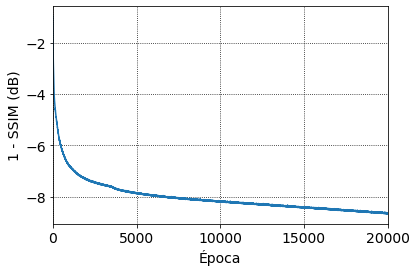

In [28]:
# list all data in history
print(history.history.keys())
# summarize history for loss
#plt.plot(10*np.log10(history.history['val_loss']), 'r', label='Teste')
#plt.plot(10*np.log10(history.history['loss']), 'b', label='Treino')
plt.plot(10*np.log10(history.history['loss']))
#plt.legend(loc='upper right')
plt.xlim(0, 20000)
plt.grid(color='black', linestyle='dotted')
plt.ylabel('1 - SSIM (dB)')
plt.xlabel('Época')
plt.savefig('salvos/rgb35(7, 7)_ssim_tanh_v2/error.eps', format='eps')
plt.show()

In [29]:
val_loss = np.asarray(history.history['val_loss'])
loss = np.asarray(history.history['loss'])
np.save('salvos/rgb35(7, 7)_ssim_tanh_v2/val_loss.npy', val_loss)
np.save('salvos/rgb35(7, 7)_ssim_tanh_v2/loss.npy', loss)

In [30]:
test_prediction = model.predict(blurred_test)
test_prediction = (1+test_prediction)/2
test_prediction_tf = tf.convert_to_tensor(test_prediction, np.float64)

**Sigma = 3**

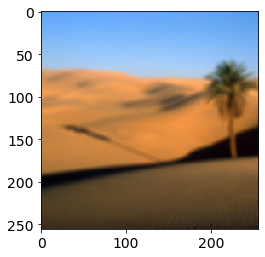

In [31]:
plt.imshow(blurred_test_aux[0 , :, :, :])

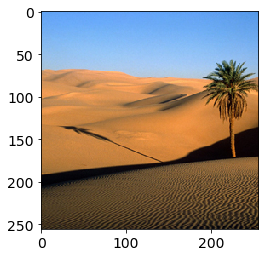

In [32]:
plt.imshow(original_test_aux[0, :, :, :])

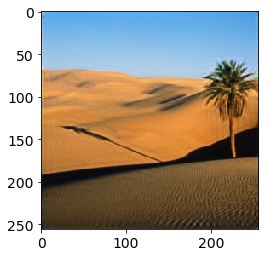

In [33]:
plt.imshow(test_prediction[0, :, :, :])

In [34]:
tf.image.ssim(original_test_tf[0, :, :, :], blurred_test_tf[0, :, :, :], max_val=1).numpy()

0.7158169

In [35]:
tf.image.ssim(original_test_tf[0, :, :, :], test_prediction_tf[0, :, :, :], max_val=1).numpy()


0.8198757

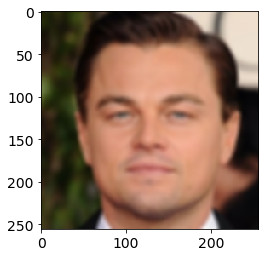

In [36]:
plt.imshow(blurred_test_aux[1, :, :, :])

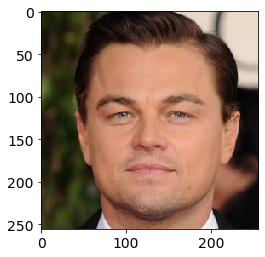

In [37]:
plt.imshow(original_test_aux[1, :, :, :])

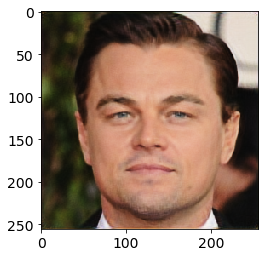

In [38]:
plt.imshow(test_prediction[1, :, :, :])


In [39]:
tf.image.ssim(original_test_tf[1, :, :, :], blurred_test_tf[1, :, :, :], max_val=1).numpy()

0.8852615

In [40]:
tf.image.ssim(original_test_tf[1, :, :, :], test_prediction_tf[1, :, :, :], max_val=1).numpy()

0.9340554

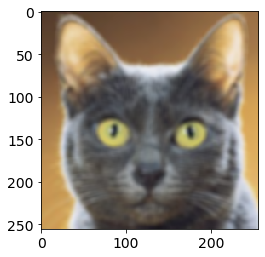

In [41]:
plt.imshow(blurred_test_aux[2 , :, :, :])

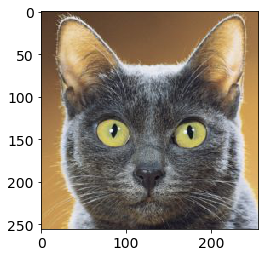

In [42]:
plt.imshow(original_test_aux[2, :, :, :])

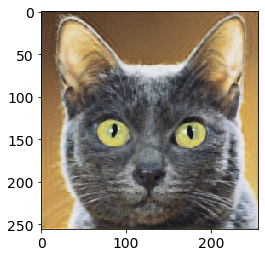

In [43]:
plt.imshow(test_prediction[2, :, :, :])

In [44]:
tf.image.ssim(original_test_tf[2, :, :, :], blurred_test_tf[2, :, :, :], max_val=1).numpy()

0.652068

In [45]:
tf.image.ssim(original_test_tf[2, :, :, :], test_prediction_tf[2, :, :, :], max_val=1).numpy()


0.86569446

**Sigma = 5**

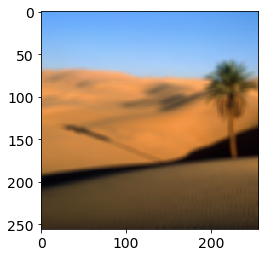

In [46]:
plt.imshow(blurred_test_aux[3, :, :, :])

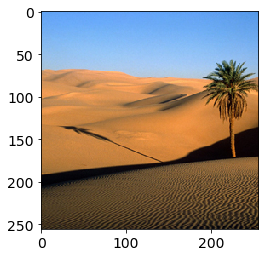

In [47]:
plt.imshow(original_test_aux[3, :, :, :])

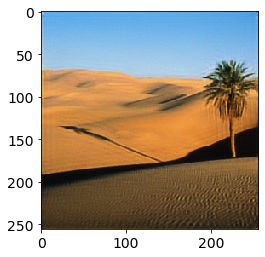

In [48]:
plt.imshow(test_prediction[3, :, :, :])

In [49]:
tf.image.ssim(original_test_tf[3, :, :, :], blurred_test_tf[3, :, :, :], max_val=1).numpy()

0.7033755

In [50]:
tf.image.ssim(original_test_tf[3, :, :, :], test_prediction_tf[3, :, :, :], max_val=1).numpy()


0.82487917

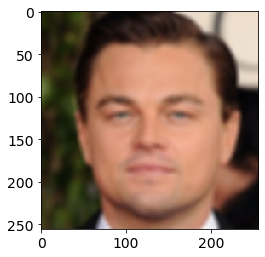

In [51]:
plt.imshow(blurred_test_aux[4, :, :, :])

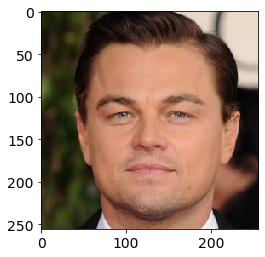

In [52]:
plt.imshow(original_test_aux[4, :, :, :])

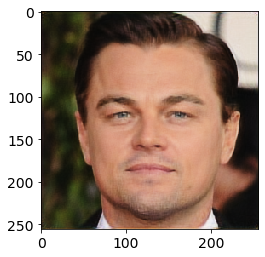

In [53]:
plt.imshow(test_prediction[4, :, :, :])

In [54]:
tf.image.ssim(original_test_tf[4, :, :, :], blurred_test_tf[4, :, :, :], max_val=1).numpy()

0.8743012

In [55]:
tf.image.ssim(original_test_tf[4, :, :, :], test_prediction_tf[4, :, :, :], max_val=1).numpy()


0.93575317

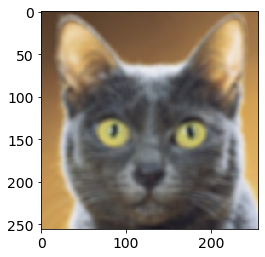

In [56]:
plt.imshow(blurred_test_aux[5, :, :, :])

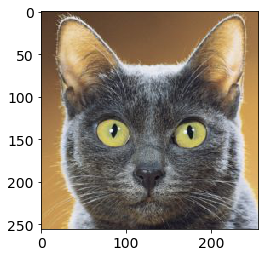

In [57]:
plt.imshow(original_test_aux[5, :, :, :])

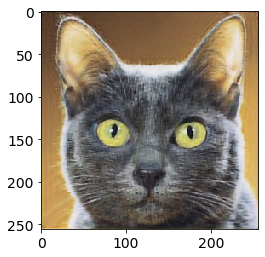

In [58]:
plt.imshow(test_prediction[5, :, :, :])


In [59]:
tf.image.ssim(original_test_tf[5, :, :, :], blurred_test_tf[5, :, :, :], max_val=1).numpy()

0.6292817

In [60]:
tf.image.ssim(original_test_tf[5, :, :, :], test_prediction_tf[5, :, :, :], max_val=1).numpy()

0.86633843

In [61]:
model.save('salvos/rgb35(7, 7)_ssim_tanh_v2/rgb35(7, 7)_ssim_tanh_v2.h5')